In [27]:
import glob
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

DATA_DIR = Path("/misc/vlgscratch4/LakeGroup/shared_data/S_multimodal")
EVALUATION_FRAMES_DIR = DATA_DIR / "eval_filtered" / "dev"

In [28]:
eval_categories = sorted(os.listdir(EVALUATION_FRAMES_DIR))
print(eval_categories)

['ball', 'basket', 'car', 'cat', 'chair', 'computer', 'crib', 'door', 'floor', 'foot', 'ground', 'hand', 'kitchen', 'paper', 'puzzle', 'road', 'room', 'sand', 'stairs', 'table', 'toy', 'window']


road


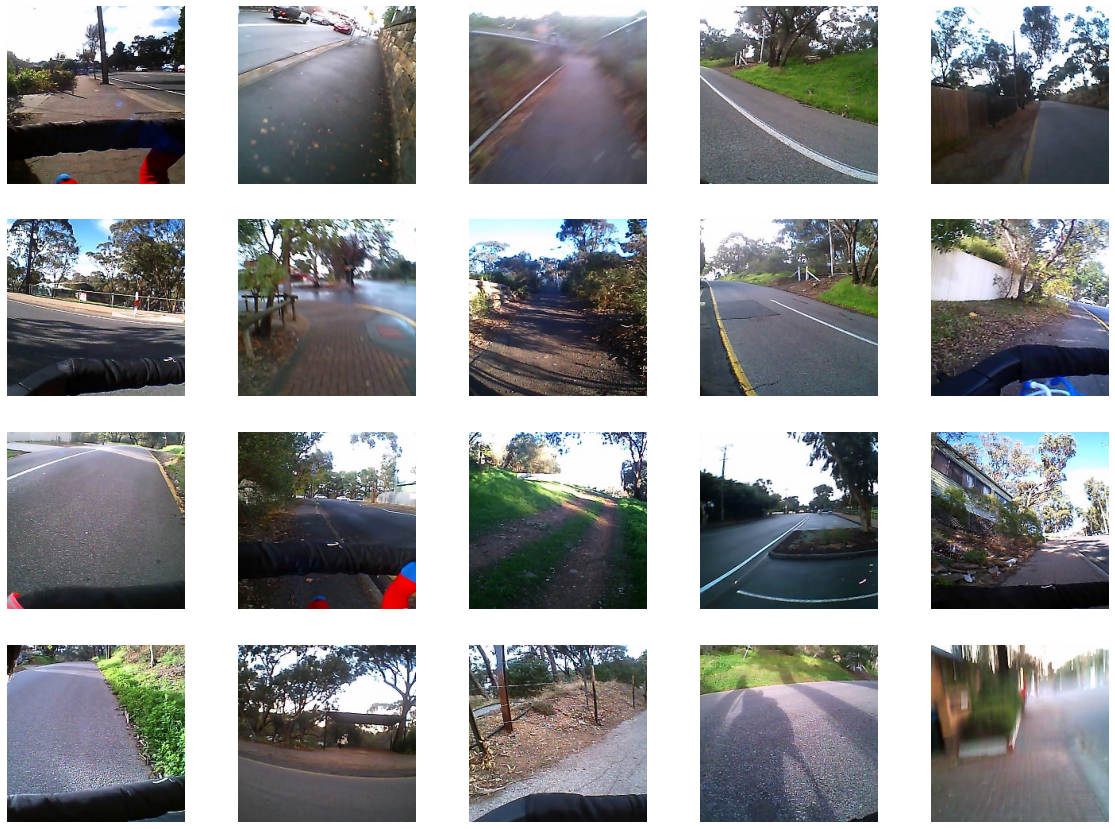

In [29]:
eval_category = np.random.choice(eval_categories)
print(eval_category)
frames = glob.glob(os.path.join(EVALUATION_FRAMES_DIR, eval_category, "*.jpeg"))
subset = np.random.choice(frames, size=20, replace=False)

plt.figure(figsize=(20, 15))
for i, frame in enumerate(subset):
    plt.subplot(4, 5, i+1)
    I = Image.open(frame)
    plt.imshow(I)
    plt.axis('off')


In [30]:
import torch
import clip
from sklearn.manifold import TSNE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, preprocess = clip.load("ViT-B/16", device=device)
model.eval()

all_image_features = []

for eval_category in eval_categories:
    frames = sorted(glob.glob(os.path.join(EVALUATION_FRAMES_DIR, eval_category, "*.jpeg")))
    print(eval_category, len(frames))
    subset = np.random.choice(frames, size=100, replace=True)
    
    for frame in subset:
        I = preprocess(Image.open(frame).convert('RGB')).unsqueeze(0).to(device)
        image_features = model.encode_image(I)
        all_image_features.append(image_features.squeeze().detach().cpu().numpy())

ball 567
basket 47
car 332
cat 346
chair 181
computer 412
crib 157
door 108
floor 872
foot 184
ground 587
hand 380
kitchen 460
paper 256
puzzle 899
road 931
room 280
sand 209
stairs 150
table 564
toy 1402
window 249


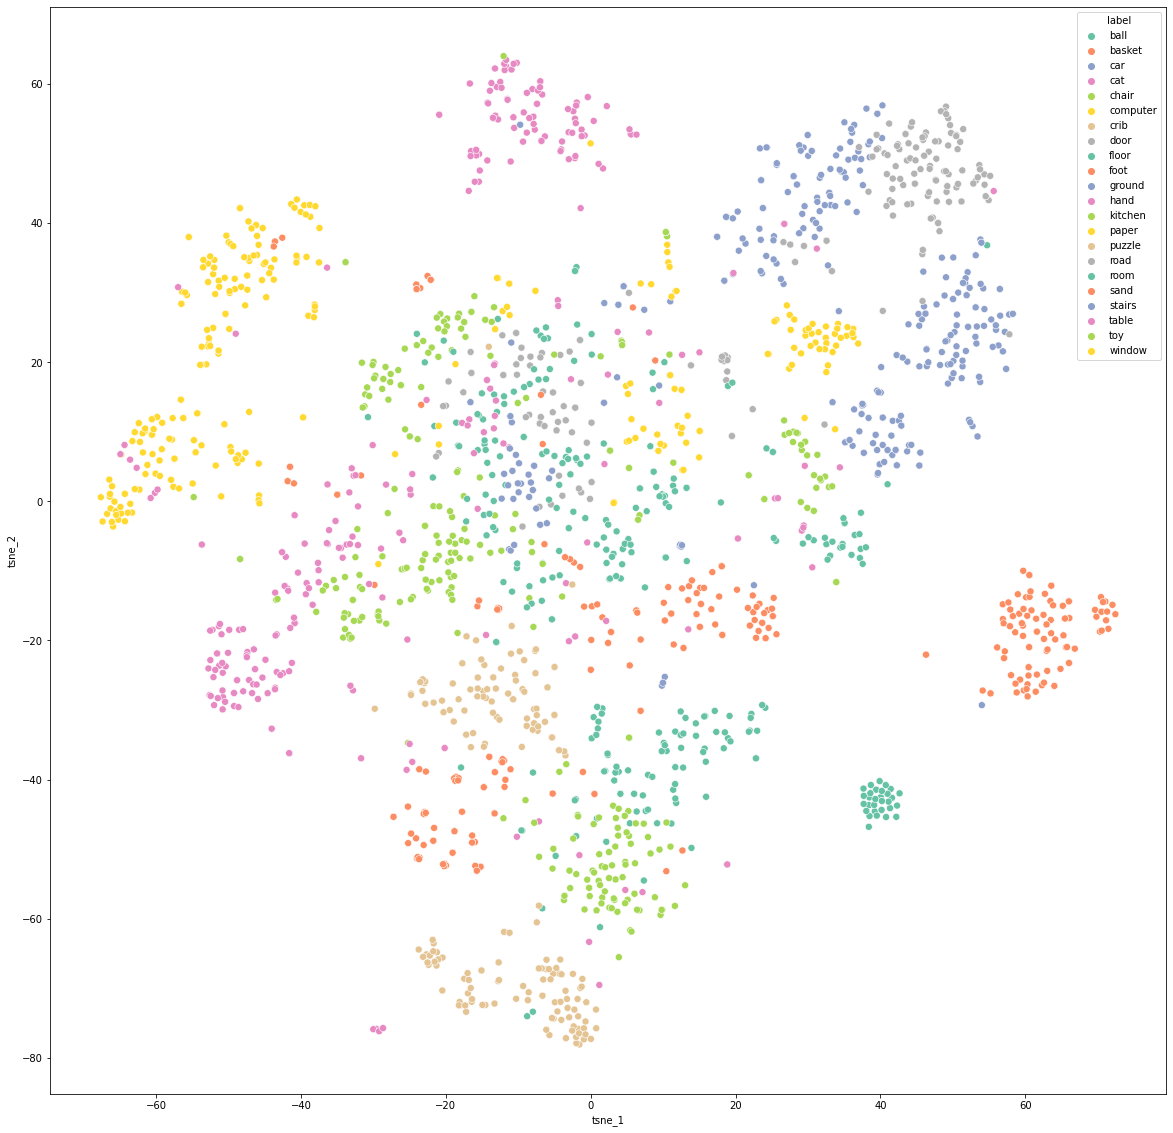

In [31]:
import pandas as pd
import seaborn as sns

sns.set_palette(sns.color_palette("Set2", len(eval_categories)))

y = []
for eval_category in eval_categories:
    for j in range(100):
        y.append(eval_category)

# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(all_image_features)
tsne_result.shape
# (1000, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
fig = plt.figure(figsize=(20, 20))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, s=50, legend="full")
lim = (tsne_result.min()-5, tsne_result.max()+5)